# <b>1 <span style='color:#4285f4'>|</span> Importing libraries</b>
- **For ML Models**: Tensorflow, keras
- **For Data Manipulation**: numpy, pandas, sklearn
- **For Data Visualization**: matplotlib, seaborn

In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

# <b>2 <span style='color:#4285f4'>|</span> Reading the Dataset</b>

In [11]:
#train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
#test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'
train_dir = '/Users/aptes/Desktop/brain-tumor-dataset/Training/'
test_dir = '/Users/aptes/Desktop/brain-tumor-dataset/Testing/'


train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

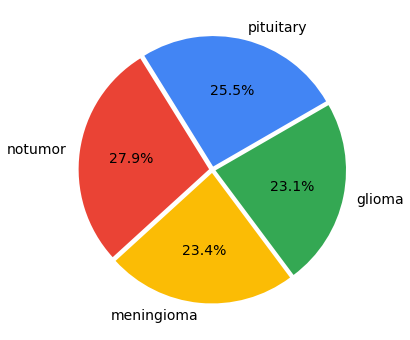

In [12]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

#### The dataset is reasonably balanced

In [13]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

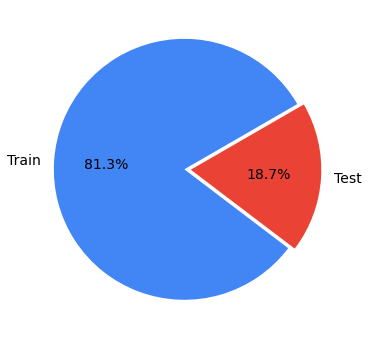

In [14]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

# <b>3 <span style='color:#4285f4'>|</span> Data Augmentation</b>
- Random Brightness: 80% - 120%  
- Random Contrast: 80% - 120%


In [15]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

<h3 style="font-family:Sans;">Let's plot some Samples :</h3>

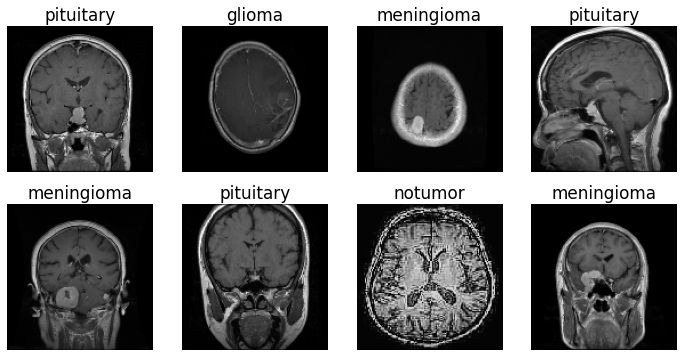

In [16]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

# <b>4 <span style='color:#4285f4'>|</span> Data Generator</b>
<p style="font-size:15px; font-family:Sans; line-height: 1.7em">
    Given a list of paths to images, and the labels, <br>
    this function augments the images, normalizes them, encodes the label, and then returns the batch on which the model can train on. <br>
</p>

In [17]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# <b>5 <span style='color:#4285f4'>|</span> Model</b>

### I am using **VGG16** for transfer learning

In [18]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

58889256/58889256 [==============================] - 11s 0us/step


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
Non

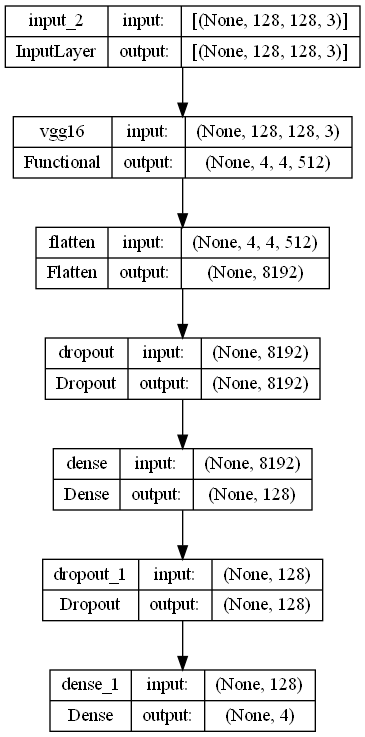

In [20]:
keras.utils.plot_model(model, show_shapes=True)

In [21]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

# <b>6 <span style='color:#4285f4'>|</span> Train Model</b>

In [22]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 4
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/4
285/285 [==============================] - 419s 1s/step - loss: 0.4376 - sparse_categorical_accuracy: 0.8319
Epoch 2/4
285/285 [==============================] - 427s 2s/step - loss: 0.2298 - sparse_categorical_accuracy: 0.9129
Epoch 3/4
285/285 [==============================] - 423s 1s/step - loss: 0.1538 - sparse_categorical_accuracy: 0.9434
Epoch 4/4
285/285 [==============================] - 458s 2s/step - loss: 0.1058 - sparse_categorical_accuracy: 0.9622


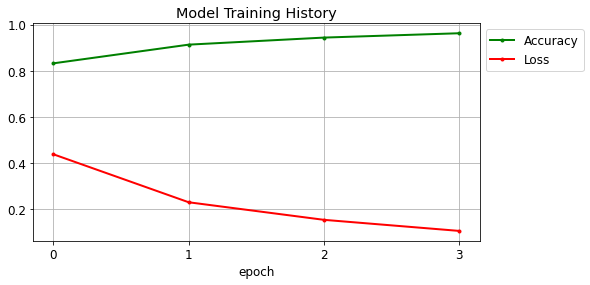

In [23]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# <b>7 <span style='color:#4285f4'>|</span> Evaluate Model with Test Samples</b>

In [24]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  2%|▎         | 1/40 [00:01<01:14,  1.91s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 2/40 [00:03<01:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 3/40 [00:05<01:04,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 4/40 [00:07<01:02,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▎        | 5/40 [00:08<01:01,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 6/40 [00:10<01:00,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 7/40 [00:12<00:58,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 8/40 [00:14<00:57,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▎       | 9/40 [00:16<00:56,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 10/40 [00:18<00:57,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 11/40 [00:20<00:58,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 12/40 [00:22<00:57,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▎      | 13/40 [00:24<00:54,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 14/40 [00:26<00:52,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 15/40 [00:28<00:50,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 16/40 [00:30<00:48,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▎     | 17/40 [00:32<00:46,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 18/40 [00:34<00:45,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 19/40 [00:36<00:43,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 20/40 [00:38<00:41,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▎    | 21/40 [00:40<00:38,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 22/40 [00:42<00:36,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▊    | 23/40 [00:44<00:33,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 24/40 [00:46<00:32,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▎   | 25/40 [00:48<00:29,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 26/40 [00:50<00:28,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 27/40 [00:52<00:26,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 28/40 [00:54<00:23,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▎  | 29/40 [00:56<00:21,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 30/40 [00:58<00:20,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 31/40 [01:01<00:18,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 32/40 [01:03<00:16,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▎ | 33/40 [01:05<00:14,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 34/40 [01:07<00:12,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 35/40 [01:09<00:10,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 36/40 [01:11<00:08,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▎| 37/40 [01:13<00:06,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 38/40 [01:15<00:04,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 39/40 [01:17<00:02,  2.05s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 40/40 [01:19<00:00,  2.01s/it]

1/1 [==============================] - 2s 2s/step


41it [01:21,  1.99s/it]                        


In [26]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.97      0.85      0.90       300
  meningioma       0.88      0.92      0.90       306
     notumor       0.95      1.00      0.97       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



In [29]:
model_version=2
model.save(r"C:\Users\aptes\Desktop\TY MIT\S6\TY\model1")

INFO:tensorflow:Assets written to: C:\Users\aptes\Desktop\TY MIT\S6\TY\models{model_version}\assets


INFO:tensorflow:Assets written to: C:\Users\aptes\Desktop\TY MIT\S6\TY\models{model_version}\assets
